### Colaps all markdown - run the "main-model"

In [ ]:
!pip install requests beautifulsoup4 pandas numpy tqdm matplotlib seaborn python-dotenv torch scikit-learn webdriver_manager selenium

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager

GITHUB_TOKEN=""

### List of Projects - from Apache website

In [ ]:
project_list_data = open("Apache_projects.html","r").read()
# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(project_list_data, 'html.parser')

# Find all <a> tags
a_tags = soup.find_all('a')

# Extract the href and text from each <a> tag
links_and_names = [(a.text, a['href']) for a in a_tags if 'href' in a.attrs]

# Convert the list to a pandas DataFrame
df = pd.DataFrame(links_and_names, columns=['Name', 'Sublink'])

In [ ]:
def get_final_url(driver, url):
    driver.get(url)
    time.sleep(5)  # Wait for the redirect to complete
    return driver.current_url


# Configure Chrome options
options = Options()
options.add_argument('--headless')
options.add_argument('--disable-gpu')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

# Set up WebDriver using webdriver-manager
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

for i, row in df[:].iterrows():
    url = "https://projects.apache.org/" + row["Sublink"]
    # Load the page and allow time for JS to execute
    driver.get(url)
    time.sleep(10)  # Increase if needed

    # Get the fully rendered page source
    page = driver.page_source

    # Parse with BeautifulSoup
    soup = BeautifulSoup(page, 'html.parser')
    
    # Find all <li> tags containing <b>Git repository:</b>
    li_tags = soup.find_all('li')
    git_repo_link = None
    for li in li_tags:
        b_tag = li.find('b')
        if b_tag and b_tag.text == 'Git repository:':
            a_tag = li.find('a', href=True)
            if a_tag:
                git_repo_link = a_tag['href']
                break
    
    project_status = None
    for li in li_tags:
        b_tag = li.find('b')
        if b_tag and b_tag.get_text(strip=True) == 'Project status:':
            # Prefer extracting text from the <span> tag
            span_tag = li.find('span')
            if span_tag:
                project_status = span_tag.get_text(strip=True)
            else:
                # Fallback extraction if span is missing
                project_status = li.get_text(strip=True).split(":", 1)[-1].strip()
            break

    # If the git_repo_link points to an .apache.org page, get its final URL
    if git_repo_link and '.apache.org' in git_repo_link:
        git_repo_link = get_final_url(driver, git_repo_link)
    
    print("Git Repository Link:", git_repo_link)
    print("Project Status:", project_status)
    
    # Update DataFrame columns (ensure these columns exist in df)
    df.at[i, "Github_link"] = git_repo_link
    df.at[i, "Project_status"] = project_status

driver.quit()

# Print and save the DataFrame to CSV
print(df)
df.to_csv("Apache_projects.csv", index=False)

2025-03-12 07:35:05,237 - INFO - ====== WebDriver manager ======
2025-03-12 07:35:06,138 - INFO - Get LATEST chromedriver version for google-chrome
2025-03-12 07:35:06,609 - INFO - Get LATEST chromedriver version for google-chrome
2025-03-12 07:35:10,395 - INFO - Driver [C:\Users\abhijeet\.wdm\drivers\chromedriver\win64\134.0.6998.88\chromedriver-win32/chromedriver.exe] found in cache


Git Repository Link: https://github.com/apache/db-jdo
Project Status: Active
Git Repository Link: https://github.com/apache/ant-antlibs-dotnet
Project Status: Active
Git Repository Link: https://github.com/apache/accumulo
Project Status: Active
Git Repository Link: None
Project Status: Active
Git Repository Link: https://github.com/apache/age
Project Status: Active
Git Repository Link: https://github.com/apache/airavata
Project Status: Active
Git Repository Link: https://github.com/apache/airflow.git
Project Status: Active
Git Repository Link: None
Project Status: Active
Git Repository Link: https://github.com/apache/ambari
Project Status: Active
Git Repository Link: None
Project Status: Incubating
Git Repository Link: None
Project Status: Active
Git Repository Link: http://git@github.com:apache/incubator-annotator.git
Project Status: Incubating
Git Repository Link: None
Project Status: Active
Git Repository Link: https://github.com/apache/ant
Project Status: Active
Git Repository Link

In [13]:
df = pd.read_csv("Apache_projects.csv")
df

,Name,Sublink,Github_link,Project_status
0,Apache JDO,project.html?db-_jdo,https://github.com/apache/db-jdo,Active
1,Apache .NET Ant Library,project.html?ant-dotnet,https://github.com/apache/ant-antlibs-dotnet,Active
2,Apache Accumulo,project.html?accumulo,https://github.com/apache/accumulo,Active
3,Apache ActiveMQ,project.html?activemq,NaN,Active
4,Apache AGE,project.html?age,https://github.com/apache/age,Active
...,...,...,...,...
382,Apache XTable (Incubating),project.html?incubator-xtable,NaN,NaN
383,Apache Yetus,project.html?yetus,NaN,NaN
384,Apache YuniKorn,project.html?yunikorn,NaN,NaN
385,Apache Zeppelin,project.html?zeppelin,NaN,NaN


### List of Projects - from Apache incubator projects

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import time

def parse_project_table(soup, section_id, project_type):

    header = soup.find("h3", id=section_id)
    if header is None:
        print(f"Section with id '{section_id}' not found.")
        return pd.DataFrame()
    
    table = header.find_next("table")
    if table is None:
        print(f"No table found after section '{section_id}'.")
        return pd.DataFrame()
    
    rows = table.find_all("tr")
    data = []
    # Skip header row (first row)
    for row in rows[1:]:
        row_id = row.get("id", "").strip()
        cells = row.find_all("td")
        # Ensure that there are at least 7 cells
        if len(cells) < 7:
            continue
        
        first_cell = cells[0]
        a_tag = first_cell.find("a", href=True)
        href = a_tag["href"] if a_tag and a_tag["href"].startswith("/projects/") else ""
        
        apache_sponsor = cells[3].get_text(strip=True)
        mentors = cells[4].get_text(strip=True)
        start_date = cells[5].get_text(strip=True)
        end_date = cells[6].get_text(strip=True)
        
        data.append({
            "id": row_id,
            "href": href,
            "type": project_type,
            "Apache Sponsor": apache_sponsor,
            "Mentors": mentors,
            "Start Date": start_date,
            "End Date": end_date
        })
    
    return pd.DataFrame(data)

def extract_all_repo_links(project_url):
    
    try:
        response = requests.get(project_url)
        response.raise_for_status()
        page_soup = BeautifulSoup(response.text, "html.parser")
    except Exception as e:
        print(f"Error fetching {project_url}: {e}")
        return [], []
    
    github_links = []
    gitbox_links = []
    
    for a in page_soup.find_all("a", href=True):
        href = a["href"]
        if "github.com" in href:
            github_links.append(href)
        if "gitbox" in href:
            gitbox_links.append(href)
    
    return github_links, gitbox_links

def main():
    # Read the HTML content from the file
    with open("Apache_incubator_projects.html", "r", encoding="utf-8") as f:
        html_content = f.read()
        
    soup = BeautifulSoup(html_content, "html.parser")
    
    # Parse the two project tables
    df_graduated = parse_project_table(soup, "graduated", "Graduated Projects")
    df_retired   = parse_project_table(soup, "retired", "Retired Podlings")
    
    # Combine DataFrames
    combined_df = pd.concat([df_graduated, df_retired], ignore_index=True)
    
    # We'll store the lists of repo links in two new columns
    combined_df["github_links"] = ''
    combined_df["gitbox_links"] = ''
    
    base_url = "https://incubator.apache.org"
    
    for idx, row in combined_df.iterrows():
        href = row["href"]
        if not href:
            combined_df.at[idx, "github_links"] = []
            combined_df.at[idx, "gitbox_links"] = []
            continue
        project_url = base_url + href
        print(f"Processing: {project_url}")
        github_list, gitbox_list = extract_all_repo_links(project_url)
        combined_df.at[idx, "github_links"] = github_list
        combined_df.at[idx, "gitbox_links"] = gitbox_list
        # Be polite to the server
        time.sleep(1)
    
    # Determine the maximum number of GitHub and Gitbox links across all projects
    max_github = max(len(links) for links in combined_df["github_links"])
    max_gitbox = max(len(links) for links in combined_df["gitbox_links"])
    
    # For each index, create separate columns for each GitHub link (github_link1, github_link2, ...)
    for i in range(max_github):
        col_name = f"github_link{i+1}"
        combined_df[col_name] = combined_df["github_links"].apply(lambda links: links[i] if len(links) > i else "")
    
    # Similarly, create separate columns for each Gitbox link (gitbox_link1, gitbox_link2, ...)
    for i in range(max_gitbox):
        col_name = f"gitbox_link{i+1}"
        combined_df[col_name] = combined_df["gitbox_links"].apply(lambda links: links[i] if len(links) > i else "")
    
    # Optionally, drop the temporary list columns
    combined_df.drop(columns=["github_links", "gitbox_links"], inplace=True)
    
    # For demonstration, print the updated DataFrame
    print("\nUpdated DataFrame with individual GitHub and Gitbox link columns:")
    print(combined_df.to_string(index=False))
    
    # Save the DataFrame to a CSV file
    combined_df.to_csv("Apache_incubator_projects.csv", index=False)
    
    return combined_df

main()


Processing: https://incubator.apache.org/projects/abdera.html
Processing: https://incubator.apache.org/projects/accumulo.html
Processing: https://incubator.apache.org/projects/ace.html
Processing: https://incubator.apache.org/projects/activemq.html
Processing: https://incubator.apache.org/projects/age.html
Processing: https://incubator.apache.org/projects/airavata.html
Processing: https://incubator.apache.org/projects/airflow.html
Processing: https://incubator.apache.org/projects/allura.html
Processing: https://incubator.apache.org/projects/ambari.html
Processing: https://incubator.apache.org/projects/amber.html
Processing: https://incubator.apache.org/projects/answer.html
Processing: https://incubator.apache.org/projects/any23.html
Processing: https://incubator.apache.org/projects/apex.html
Processing: https://incubator.apache.org/projects/apisix.html
Processing: https://incubator.apache.org/projects/apollo.html
Processing: https://incubator.apache.org/projects/aries.html
Processing: 

,id,href,type,Apache Sponsor,Mentors,Start Date,End Date,github_link1,github_link2,github_link3,...,gitbox_link1,gitbox_link2,gitbox_link3,gitbox_link4,gitbox_link5,gitbox_link6,gitbox_link7,gitbox_link8,gitbox_link9,gitbox_link10
0,abdera,/projects/abdera.html,Graduated Projects,Incubator,"Garrett Rooney, Paul Querna",2006-06-06,2008-11-08,,,,...,,,,,,,,,,
1,accumulo,/projects/accumulo.html,Graduated Projects,Incubator,"Benson Margulies, Alan Cabrera, Bernd Fondermann",2011-09-12,2012-03-21,,,,...,,,,,,,,,,
2,ace,/projects/ace.html,Graduated Projects,Board,"Niclas Hedhman, Carsten Ziegeler, Bertrand Del...",2009-04-24,2011-12-21,,,,...,,,,,,,,,,
3,activemq,/projects/activemq.html,Graduated Projects,Geronimo,James Strachan,2005-12-01,2007-02-06,,,,...,,,,,,,,,,
4,age,/projects/age.html,Graduated Projects,Incubator(Jim Jagielski),"Kevin Ratnasekera, Von Gosling, Felix Cheung, ...",2020-04-29,2022-05-18,,,,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324,xap,/projects/xap.html,Retired Podlings,Incubator,"Cliff Schmidt, Robert Burrell Donkin, Susan Wu",2006-05-22,2009-06-26,,,,...,,,,,,,,,,
325,xmlbeanscxx,/projects/xmlbeanscxx.html,Retired Podlings,Web Services,Cliff Schmidt,2005-06-06,2007-05-16,,,,...,,,,,,,,,,
326,yoko,/projects/yoko.html,Retired Podlings,Geronimo,"Ken Coar, Geir Magnusson Jr., James Strachan",2006-01-31,2007-12-17,,,,...,,,,,,,,,,
327,zetacomponents,/projects/zetacomponents.html,Retired Podlings,Incubator,"Julien Vermillard, Christian Grobmeier, Craig ...",2010-05-21,2012-04-20,http://github.com/zetacomponents,,,...,,,,,,,,,,


### List of Projects - from Apache github projects

In [ ]:
import requests
import pandas as pd
import time
from tqdm import tqdm

# GitHub API URL and token
GITHUB_API_URL = "https://api.github.com"

# Headers for API Authentication
HEADERS = {'Authorization': f'token {GITHUB_TOKEN}'}

def fetch_repositories(org):
    repos = []
    page = 1
    while True:
        url = f"{GITHUB_API_URL}/orgs/{org}/repos?page={page}&per_page=100"
        response = requests.get(url, headers=HEADERS)
        if response.status_code != 200:
            print(f"Failed to fetch repositories: {response.status_code}")
            break
        data = response.json()
        if not data:
            break
        repos.extend(data)
        page += 1
        time.sleep(1)  # To avoid hitting rate limits
    return repos

def extract_repo_info(repos):
    repo_info = []
    for repo in repos:
        repo_info.append({
            'id': repo['id'],
            'node_id': repo['node_id'],
            'owner': repo['owner']['login'],
            'name': repo['name'],
            'url': repo['html_url'],
            'created_at': repo['created_at'],
            'updated_at': repo['updated_at'],
            'pushed_at': repo['pushed_at'],
            'size': repo['size'],
            'stargazers_count': repo['stargazers_count'],
            #'watchers_count': repo['watchers_count'],
            'language': repo['language'],
            'has_issues': repo['has_issues'],
            'has_projects': repo['has_projects'],
            'has_downloads': repo['has_downloads'],
            'has_wiki': repo['has_wiki'],
            'has_pages': repo['has_pages'],
            'has_discussions': repo['has_discussions'],
            'forks_count': repo['forks_count'],
            'mirror_url': repo['mirror_url'],
            'archived': repo['archived'],
            'disabled': repo['disabled'],
            'open_issues_count': repo['open_issues_count'],
            'license': repo['license'],
            'allow_forking': repo['allow_forking'],
            'is_template': repo['is_template'],
            'web_commit_signoff_required': repo['web_commit_signoff_required'],
            'forks': repo['forks'],
            'open_issues': repo['open_issues'],
            'watchers': repo['watchers'],
            'default_branch': repo['default_branch'],
            'permissions_admin': repo['permissions']['admin'],
            'permissions_maintain': repo['permissions']['maintain'],
            'permissions_push': repo['permissions']['push'],
            'permissions_pull': repo['permissions']['pull'],
        })
    return repo_info

def save_to_csv(data, filename):
   
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)
    print(f"Data saved to {filename}")

# Fetch repositories for a given organization
organization = "apache"  # Replace with the desired organization
repositories = fetch_repositories(organization)

# Extract repository information
repo_info = extract_repo_info(repositories)

# Save the repository information to a CSV file
save_to_csv(repo_info, "Apache_github_repositories.csv")

Data saved to Apache_github_repositories.csv


### Combining all 3 lists

In [ ]:
import pandas as pd

# Load your CSV files
incubator_data = pd.read_csv("Apache_incubator_projects.csv")
apache_project_data = pd.read_csv("Apache_projects.csv")
github_project_data = pd.read_csv("Apache_github_repositories.csv")


incubator_data['name_std'] = incubator_data['id'].astype(str).str.strip().str.lower()
apache_project_data['name_std'] = apache_project_data['Name'].astype(str).str[7:].str.strip().str.lower()
# For github_project_data, assume the name is in the column 'name'
github_project_data['name_std'] = github_project_data['name'].astype(str).str.strip().str.lower()



# Define the incubator columns to check for GitHub links.
incubator_link_cols = [
    "github_link1", "github_link2", "github_link3", "github_link4",
    "github_link5", "github_link6", "github_link7", "github_link8",
    "github_link9", "github_link10", "github_link11", "github_link12",
    "github_link13", "gitbox_link1", "gitbox_link2", "gitbox_link3",
    "gitbox_link4", "gitbox_link5", "gitbox_link6", "gitbox_link7",
    "gitbox_link8", "gitbox_link9", "gitbox_link10"
]


def prefixed_cols(df, prefix):
    return [f"{prefix}_{col}" for col in df.columns if col != "name_std"]

github_cols = prefixed_cols(github_project_data, "github")
apache_cols = prefixed_cols(apache_project_data, "apache")
incubator_cols = prefixed_cols(incubator_data, "incubator")

# The combined DataFrame will have columns from all three sets.
combined_columns = github_cols + apache_cols + incubator_cols


rows = []


for idx, github_row in github_project_data.iterrows():
    name = github_row['name_std']
    combined_row = {}
    
    for col in github_project_data.columns:
        if col != 'name_std':
            combined_row[f'github_{col}'] = github_row[col]
    
    apache_match = apache_project_data[apache_project_data['name_std'] == name]

    if apache_match.empty:
        apache_match = apache_project_data[apache_project_data['Github_link'] == github_row['url']]
    
    if not apache_match.empty:
        match_idx = apache_match.index[0]
        apache_row = apache_project_data.loc[match_idx]
        for col in apache_project_data.columns:
            if col != 'name_std':
                combined_row[f'apache_{col}'] = apache_row[col]
        # Remove the matched row from apache_project_data.
        apache_project_data = apache_project_data.drop(match_idx)
    else:
        # No match found; fill with NA for each Apache column.
        for col in apache_project_data.columns:
            if col != 'name_std':
                combined_row[f'apache_{col}'] = pd.NA

    incubator_match = incubator_data[incubator_data['name_std'] == name]
    if incubator_match.empty:
        incubator_match = incubator_data[incubator_data.apply(
            lambda row: any(github_row['url'] == str(row[col]).strip() for col in incubator_link_cols if pd.notna(row[col])),
            axis=1)]
    
    if not incubator_match.empty:
        match_idx = incubator_match.index[0]
        incubator_row = incubator_data.loc[match_idx]
        for col in incubator_data.columns:
            if col != 'name_std':
                combined_row[f'incubator_{col}'] = incubator_row[col]
        # Remove the matched row from incubator_data.
        incubator_data = incubator_data.drop(match_idx)
    else:
        # No match; fill with NA for each incubator column.
        for col in incubator_data.columns:
            if col != 'name_std':
                combined_row[f'incubator_{col}'] = pd.NA

    # Append the combined row dictionary to our list.
    rows.append(combined_row)

# Append any remaining Apache rows that were not matched.
for idx, apache_row in apache_project_data.iterrows():
    combined_row = {}
    # Fill GitHub columns with NA.
    for col in github_project_data.columns:
        if col != 'name_std':
            combined_row[f'github_{col}'] = pd.NA
    # Add Apache data.
    for col in apache_project_data.columns:
        if col != 'name_std':
            combined_row[f'apache_{col}'] = apache_row[col]
    # Fill Incubator columns with NA.
    for col in incubator_data.columns:
        if col != 'name_std':
            combined_row[f'incubator_{col}'] = pd.NA
    rows.append(combined_row)

# Append any remaining Incubator rows that were not matched.
for idx, incubator_row in incubator_data.iterrows():
    combined_row = {}
    # Fill GitHub and Apache columns with NA.
    for col in github_project_data.columns:
        if col != 'name_std':
            combined_row[f'github_{col}'] = pd.NA
    for col in apache_project_data.columns:
        if col != 'name_std':
            combined_row[f'apache_{col}'] = pd.NA
    # Add Incubator data.
    for col in incubator_data.columns:
        if col != 'name_std':
            combined_row[f'incubator_{col}'] = incubator_row[col]
    rows.append(combined_row)


result_df = pd.DataFrame(rows, columns=combined_columns)

def get_final_status(row):'incubator_incubator_type'
    if pd.notna(row.get('incubator_type', None)):
        if row['incubator_type'] == "Graduated Projects":
            return 1
        elif row['incubator_type'] == "Retired Podlings":
            return 0'apache_Project_status'
    if pd.notna(row.get('apache_Project_status', None)):
        status = row['apache_Project_status']
        if status == "Incubating":
            return -1
        elif status == "Active":
            return 1
        elif status == "Retired":
            return 0'github_github_archived'
    if pd.notna(row.get('github_archived', None)):
        archived = row['github_archived']
        # Assuming archived is boolean or a string representation.
        if archived in [True, 'True', 'true', 1]:
            return 0
        else:
            return 1
    return pd.NA

# Apply the function to each row to create the final_status column.
result_df['final_status'] = result_df.apply(get_final_status, axis=1)

# Move final_status to be the leftmost column.
cols = result_df.columns.tolist()
cols.insert(0, cols.pop(cols.index('final_status')))
result_df = result_df[cols]

# Save the resulting DataFrame to a CSV file (optional).
result_df.to_csv("R_Apache_combined_data.csv", index=False)



     final_status github_id                github_node_id github_owner  \
0               0    160986  MDEwOlJlcG9zaXRvcnkxNjA5ODY=       apache   
1               1    160988  MDEwOlJlcG9zaXRvcnkxNjA5ODg=       apache   
2               0    160989  MDEwOlJlcG9zaXRvcnkxNjA5ODk=       apache   
3               1    160994  MDEwOlJlcG9zaXRvcnkxNjA5OTQ=       apache   
4               1    160995  MDEwOlJlcG9zaXRvcnkxNjA5OTU=       apache   
...           ...       ...                           ...          ...   
3020            0      <NA>                          <NA>         <NA>   
3021            0      <NA>                          <NA>         <NA>   
3022            0      <NA>                          <NA>         <NA>   
3023            0      <NA>                          <NA>         <NA>   
3024            0      <NA>                          <NA>         <NA>   

               github_name                                      github_url  \
0                tapestry3       

In [ ]:
import pandas as pd

# Read the combined CSV file
df = pd.read_csv("R_Apache_combined_data.csv")

# Filter rows that have a non-null "github_name" and at least one of "apache_Name" or "incubator_id"
df_filtered = df[
    df['github_name'].notna() &
    (df['apache_Name'].notna() | df['incubator_id'].notna())
]

# Sort the filtered rows based on "github_size"
df_sorted = df_filtered.sort_values(by="github_size")

# Split the sorted data into two groups based on final_status (0 and 1)
group_0 = df_sorted[df_sorted['final_status'] == 0]
group_1 = df_sorted[df_sorted['final_status'] == 1]

# Determine the smaller group count to balance the dataset
min_count = min(len(group_0), len(group_1))

# Select the top min_count rows from each group (as the data is sorted by github_size)
balanced_0 = group_0.tail(min_count)
balanced_1 = group_1.tail(min_count)

# Concatenate the balanced groups
balanced_df = pd.concat([balanced_0, balanced_1]).sort_values(by="github_size")

# (Optional) Save the balanced dataframe to a CSV file
balanced_df.to_csv("R_Apache_balanced_data.csv", index=False)



### Gets the data from github api 

In [ ]:
import os
import time
import json
import requests
import pandas as pd
import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from tqdm import tqdm

HEADERS = {
    "Accept": "application/vnd.github.v3+json",
    "Authorization": f"token {GITHUB_TOKEN}"
}
BASE_URL = "https://api.github.com"


def get_with_retries(url, headers, retries=3, timeout=10):
    for i in range(retries):
        try:
            response = requests.get(url, headers=headers)
            response.raise_for_status()
            return response
        except requests.exceptions.RequestException as error:
            print(f"Attempt {i+1} failed for URL:\n{url}\nError: {error}")
            time.sleep(2**i)  # Exponential backoff
    print(f"Failed to fetch {url} after {retries} attempts")
    return None


def get_commits(repo_full_name, month):
    # month: "YYYY-MM" string
    split_year, split_month = map(int, month.split("-"))
    start_date = datetime.date(split_year, split_month, 1)
    if split_month == 12:
        end_date = datetime.date(split_year + 1, 1, 1) - timedelta(days=1)
    else:
        end_date = datetime.date(split_year, split_month + 1, 1) - timedelta(days=1)
    url = f"{BASE_URL}/repos/{repo_full_name}/commits?since={start_date}&until={end_date}&per_page=100"
    response = get_with_retries(url, HEADERS)
    if response:
        return len(response.json())
    return 0

def get_pull_requests(repo_full_name, month):
    split_year, split_month = map(int, month.split("-"))
    start_date = datetime.date(split_year, split_month, 1)
    if split_month == 12:
        end_date = datetime.date(split_year + 1, 1, 1) - timedelta(days=1)
    else:
        end_date = datetime.date(split_year, split_month + 1, 1) - timedelta(days=1)
    url = f"{BASE_URL}/search/issues?q=repo:{repo_full_name}+is:pr+closed:{start_date}..{end_date}"
    response = get_with_retries(url, HEADERS)
    if response:
        data = response.json()
        return data.get("total_count", 0)
    return 0

def get_issues_resolved(repo_full_name, month):
    split_year, split_month = map(int, month.split("-"))
    start_date = datetime.date(split_year, split_month, 1)
    if split_month == 12:
        end_date = datetime.date(split_year + 1, 1, 1) - timedelta(days=1)
    else:
        end_date = datetime.date(split_year, split_month + 1, 1) - timedelta(days=1)
    url = f"{BASE_URL}/search/issues?q=repo:{repo_full_name}+is:issue+closed:{start_date}..{end_date}"
    response = get_with_retries(url, HEADERS)
    if response:
        data = response.json()
        return data.get("total_count", 0)
    return 0

def get_milestones_completed(repo_full_name, month):
    url = f"{BASE_URL}/repos/{repo_full_name}/milestones?state=closed&per_page=100"
    response = get_with_retries(url, HEADERS)
    if response:
        milestones = response.json()
        # Check if the milestone was closed in the given month ("YYYY-MM")
        return sum(1 for milestone in milestones if milestone.get("closed_at", "")[:7] == month)
    return 0

def get_code_churn(repo_full_name, month):
    split_year, split_month = map(int, month.split("-"))
    start_date = datetime.date(split_year, split_month, 1)
    if split_month == 12:
        end_date = datetime.date(split_year + 1, 1, 1) - timedelta(days=1)
    else:
        end_date = datetime.date(split_year, split_month + 1, 1) - timedelta(days=1)
    url = f"{BASE_URL}/repos/{repo_full_name}/commits?since={start_date}&until={end_date}&per_page=100"
    response = get_with_retries(url, HEADERS)
    if not response:
        return 0, 0
    commits = response.json()
    lines_added, lines_removed = 0, 0
    for commit in commits:
        commit_url = commit["url"]
        commit_resp = get_with_retries(commit_url, HEADERS)
        if commit_resp:
            commit_details = commit_resp.json()
            if "stats" in commit_details:
                # Ensure the commit falls in the given month (using YYYY-MM from the commit date)
                commit_month = commit_details["commit"]["author"]["date"][:7]
                if commit_month == month:
                    lines_added += commit_details["stats"].get("additions", 0)
                    lines_removed += commit_details["stats"].get("deletions", 0)
    return lines_added, lines_removed

def get_mails_per_month(repo_full_name, month):
    split_year, split_month = map(int, month.split("-"))
    start_date = datetime.date(split_year, split_month, 1)
    url = f"{BASE_URL}/repos/{repo_full_name}/issues/comments?since={start_date}&per_page=100"
    response = get_with_retries(url, HEADERS)
    if response:
        comments = response.json()
        return sum(1 for comment in comments if comment.get("created_at", "")[:7] == month)
    return 0


def calculate_composite_score(data):
    weights = {
        'commits': 20,
        'pull_requests': 15,
        'issues_resolved': 20,
        'milestones': 20,
        'code_churn': 10,
        'community_engagement': 15
    }
    score = 0
    for metric, weight in weights.items():
        previous = data[metric]['previous']
        # Avoid division by zero; if no previous data, percent change is 0.
        percent_change = (data[metric]['current'] - previous) / previous if previous > 0 else 0
        score += percent_change * (weight / 100)
    return score

def assign_label(score):
    if score > 0.30:
        return 'Accelerating'
    elif 0.10 < score <= 0.30:
        return 'Consolidating'
    elif 0.00 < score <= 0.10:
        return 'Maintaining'
    elif -0.10 < score <= 0.00:
        return 'Plateauing'
    elif -0.30 < score <= -0.10:
        return 'Declining'
    elif score <= -0.30:
        return 'Crisis'
    else:
        return 'Data Insufficient'

def map_label_to_number(label):
    label_mapping = {
        "Accelerating": 6,
        "Consolidating": 5,
        "Maintaining": 4,
        "Plateauing": 3,
        "Declining": 2,
        "Crisis": 1
    }
    return label_mapping.get(label, -1)  # Return -1 for unknown labels

def convert_month_format(month):
    """Convert 'YYYY-MM' to 'YYMM' format."""
    year, month_num = month.split("-")
    return f"{year[-2:]}{month_num}"


def fetch_monthly_metrics(owner, repo, start_date, end_date, years=2):
    
    monthly_data = []
    now = end_date.replace(day=1)
    max_years_ago = now - relativedelta(years=years)
    # Start at the later of the repo creation date or the date from 'years' ago.
    current = max(start_date.replace(day=1), max_years_ago)

    while current < now:
        next_month = current + relativedelta(months=1)
        month_str = current.strftime("%Y-%m")
        print(f"Fetching metrics for {owner}/{repo} for {month_str}...")
        commits = get_commits(f"{owner}/{repo}", month_str)
        pr_closed = get_pull_requests(f"{owner}/{repo}", month_str)
        issues_resolved = get_issues_resolved(f"{owner}/{repo}", month_str)
        milestones_completed = get_milestones_completed(f"{owner}/{repo}", month_str)
        lines_added, lines_removed = get_code_churn(f"{owner}/{repo}", month_str)
        mails = get_mails_per_month(f"{owner}/{repo}", month_str)

        monthly_data.append({
            "month": convert_month_format(month_str),  # stored as YYMM
            "commits": commits,
            "pull_requests": pr_closed,
            "issues_resolved": issues_resolved,
            "milestones": milestones_completed,
            "code_churn": lines_added - lines_removed,
            "community_engagement": mails
        })
        current = next_month
        time.sleep(1)  # To avoid rate limiting
    return monthly_data

def load_existing_data():
    try:
        with open("repository_metrics.json", "r") as f:
            return json.load(f)  # Expecting a dict keyed by repo URLs
    except (FileNotFoundError, json.JSONDecodeError):
        return {}

def main():
    # Load repository data from CSV
    df = pd.read_csv("R_Apache_balanced_data.csv")
    
    # Load previously processed repository data (as a dict keyed by GitHub URL)
    existing_data = load_existing_data()
    
    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        if pd.isna(row.get("github_url")):
            continue
        
        github_url = row["github_url"]
        # Skip if this repo has been processed already
        if github_url in existing_data:
            continue
        
        try:
            owner, repo = github_url.rstrip("/").split("/")[-2:]
        except IndexError:
            print(f"Invalid URL format: {github_url}")
            continue

        try:
            creation_date = datetime.datetime.fromisoformat(row["github_created_at"].replace("Z", "+00:00"))
            pushed_date = datetime.datetime.fromisoformat(row["github_pushed_at"].replace("Z", "+00:00"))
        except Exception as e:
            print(f"Error parsing dates for {github_url}: {e}")
            continue

        # Fetch monthly metrics (over up to 2 years)
        monthly_metrics = fetch_monthly_metrics(owner, repo, creation_date, pushed_date, years=1)
        
        monthly_scores = []
        # Need at least two months to compare
        if len(monthly_metrics) >= 2:
            for idx in range(1, len(monthly_metrics)):
                current = monthly_metrics[idx]
                previous = monthly_metrics[idx - 1]
                # Prepare data for each metric
                data = {
                    'commits': {'current': current["commits"], 'previous': previous["commits"]},
                    'pull_requests': {'current': current["pull_requests"], 'previous': previous["pull_requests"]},
                    'issues_resolved': {'current': current["issues_resolved"], 'previous': previous["issues_resolved"]},
                    'milestones': {'current': current["milestones"], 'previous': previous["milestones"]},
                    'code_churn': {'current': current["code_churn"], 'previous': previous["code_churn"]},
                    'community_engagement': {'current': current["community_engagement"], 'previous': previous["community_engagement"]}
                }
                score = calculate_composite_score(data)
                label = assign_label(score)
                monthly_scores.append({
                    "Month": current["month"],
                    "Score": score,
                    "Label": map_label_to_number(label)
                })
        
        # Build repository entry
        repo_entry = {
            "name": row.get("github_name", ""),
            "Github_link": github_url,
            "Graduated": row.get("final_status", ""),
            "start_date": creation_date.strftime("%Y-%m-%d"),
            "monthly_metrics": monthly_metrics,
            "monthly_scores": monthly_scores
        }
        
        existing_data[github_url] = repo_entry
        
        # Save after each processed repository
        with open("repository_metrics.json", "w") as f:
            json.dump(existing_data, f, indent=4)
    
    print("Data saved to repository_metrics.json")

if __name__ == "__main__":
    main()


### main model - current, it that takes the new json 

both repository_metrics repository_metrics1 are combined manually

Feature vector shape: 9 features per timestep
Feature composition: 1 (month) + 1 (score) + 7 (one-hot labels)
Input shape (X_train): (1298, 2, 9)
Ground truth shape (y_train): (1298,)
Input shape (X_test): (418, 2, 9)
Ground truth shape (y_test): (418,)
Input shape (X_valid): (418, 2, 9)
Ground truth shape (y_valid): (418,)


c:\Users\abhijeet\miniconda3\envs\tf\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_66"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_109 (LSTM)                 │ (None, 2, 64)          │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_154 (Dropout)           │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_110 (LSTM)                 │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_155 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_156 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,633 (123.57 KB)

 Trainable params: 31,633 (123.57 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.6541 - loss: 0.6955 - val_accuracy: 0.7010 - val_loss: 0.6310 - learning_rate: 5.0000e-04
Epoch 2/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7219 - loss: 0.6058 - val_accuracy: 0.7105 - val_loss: 0.5342 - learning_rate: 5.0000e-04
Epoch 3/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7407 - loss: 0.5315 - val_accuracy: 0.7177 - val_loss: 0.5156 - learning_rate: 5.0000e-04
Epoch 4/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7416 - loss: 0.5117 - val_accuracy: 0.7273 - val_loss: 0.5088 - learning_rate: 5.0000e-04
Epoch 5/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7751 - loss: 0.4860 - val_accuracy: 0.7344 - val_loss: 0.4905 - learning_rate: 5.0000e-04
Epoch 6/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7897 - loss: 0.4691 - val_accuracy: 0.7656 - val_loss: 0.4829 - learning_rate: 5.0000e-04
Epoch 7/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7852

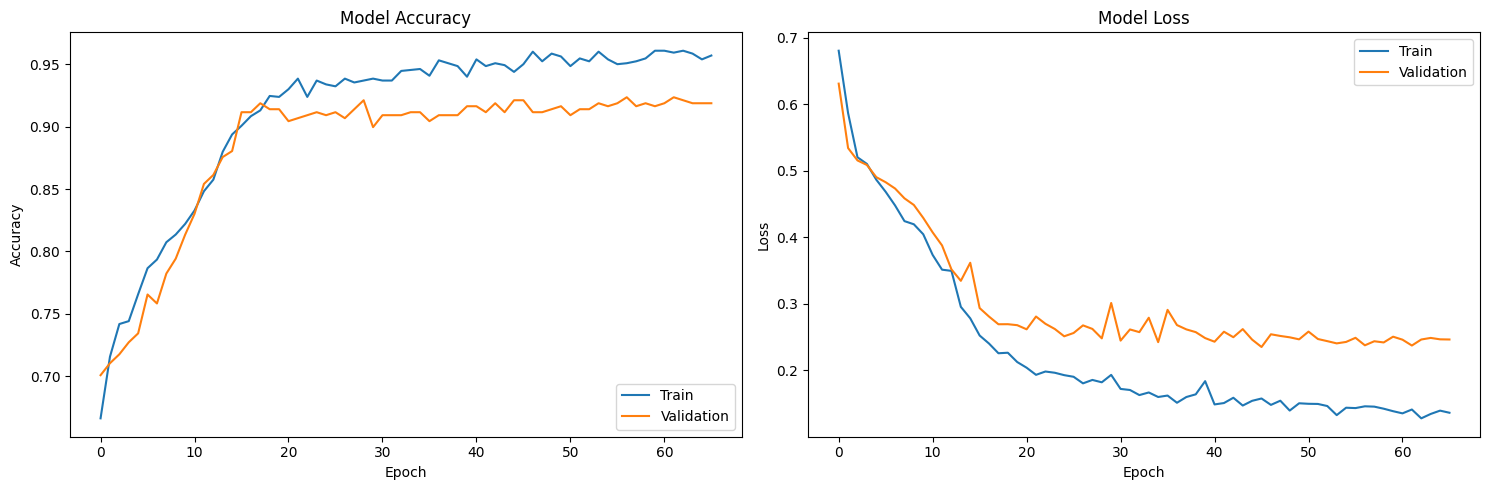

Model saved to repository_status_predictor.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
Precision: 0.9635
Recall: 0.9343
F1-Score: 0.9487


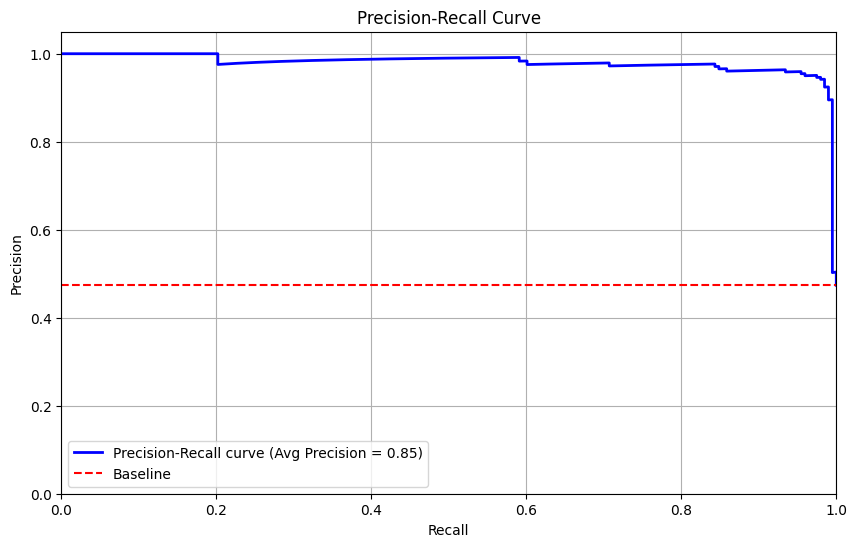


Metrics at different thresholds:
Threshold: 0.3 - Precision: 0.9461, Recall: 0.9747, F1: 0.9602
Threshold: 0.4 - Precision: 0.9505, Recall: 0.9697, F1: 0.9600
Threshold: 0.5 - Precision: 0.9635, Recall: 0.9343, F1: 0.9487
Threshold: 0.6 - Precision: 0.9628, Recall: 0.9141, F1: 0.9378
Threshold: 0.7 - Precision: 0.9609, Recall: 0.8687, F1: 0.9125


In [ ]:
import json
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve


def load_data(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    return data


def one_hot(label, num_classes=7):
    """Convert a label to one-hot encoded vector"""
    vec = np.zeros(num_classes)
    if 0 <= label < num_classes:
        vec[label] = 1
    return vec


def preprocess_data(projects_data, window_size=4, num_classes=7, test_size=0.2, valid_size=0.2, random_state=42):

    X_train, y_train = [], []
    X_test, y_test = [], []
    X_valid, y_valid = [], []
    
    # Define min and max values for normalization (YYMM format)
    min_month = 2000  
    max_month = 9900  

    n = len(projects_data)
    split_array = np.zeros(n, dtype=int)
    
    # Determine counts for each split
    n_test = int(n * test_size)
    n_valid = int(n * valid_size)

    split_array[:n_test] = 1
    split_array[n_test:n_test + n_valid] = 2
    split_array[n_test + n_valid:] = 3

    
    np.random.seed(random_state)
    np.random.shuffle(split_array)
    
    # Iterate through each project and create sliding window sequences
    for idx, project in enumerate(projects_data):
        github_link = project.get("Github_link", "Unknown")
        final_status = project.get("final_status", 0)
        monthly_metrics = project.get("monthly_metrics", [])
        
        # Sort monthly metrics by month (assuming format YYMM)
        monthly_metrics = sorted(monthly_metrics, key=lambda m: m["Month"])
        
        # Extract features
        labels = [m["Label"] for m in monthly_metrics]
        scores = [m["Score"] for m in monthly_metrics]
        months = [m["Month"] for m in monthly_metrics]
        
        # Convert months to integers and normalize to [0, 1]
        normalized_months = []
        for month_str in months:
            month_int = int(month_str)
            norm_month = (month_int - min_month) / (max_month - min_month)
            normalized_months.append(norm_month)
        
        one_hot_labels = [one_hot(label, num_classes) for label in labels]
        
        feature_vectors = []
        for i in range(len(one_hot_labels)):
            features = np.concatenate(([normalized_months[i]], [scores[i]], one_hot_labels[i]))
            feature_vectors.append(features)
        
        for i in range(len(feature_vectors) - window_size):
            X_seq = feature_vectors[i:i + window_size]
            if split_array[idx] == 1:
                X_test.append(X_seq)
                y_test.append(float(final_status))
            elif split_array[idx] == 2:
                X_valid.append(X_seq)
                y_valid.append(float(final_status))
            else:
                X_train.append(X_seq)
                y_train.append(float(final_status))
    
    # Convert lists to numpy arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    X_valid= np.array(X_valid)
    y_valid = np.array(y_valid)
    
    # Get input dimensions from the training set
    n_samples, timesteps, n_features = X_train.shape
    print(f"Feature vector shape: {n_features} features per timestep")
    print(f"Feature composition: 1 (month) + 1 (score) + {num_classes} (one-hot labels)")
    
    return X_train, X_test, X_valid, y_train, y_test, y_valid, n_features, timesteps

# Function to build the LSTM model
def build_model(timesteps, n_features):
    model = Sequential()
    
    # Input layer and first LSTM layer
    model.add(LSTM(64, input_shape=(timesteps, n_features), 
                  return_sequences=True, 
                  recurrent_dropout=0.2))
    model.add(Dropout(0.2))
    
    # Second LSTM layer
    model.add(LSTM(32, recurrent_dropout=0.2))
    model.add(Dropout(0.2))
    
    # Output layers with reduced complexity
    model.add(Dense(8, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Function to train and evaluate the model
def train_and_evaluate(model, X_train, y_train, X_test, y_test, X_valid, y_valid, epochs=100, batch_size=16):
    # Define callbacks for early stopping and learning rate reduction
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=0.00001,
        verbose=1
    )
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_valid, y_valid),
        callbacks=[early_stopping,  reduce_lr],
        verbose=1
    )
    
    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    
    return model, history

# Function to plot training history
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot training & validation accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='lower right')
    
    # Plot training & validation loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper right')
    
    plt.tight_layout()
    plt.show()

# Main execution function
def main():
    label_json = 'repository_metrics1.json'
    
    # Hyperparameters
    window_size = 2
    num_classes = 7
    epochs = 200
    batch_size = 16
    
    # Load and preprocess data
    projects_data = load_data(label_json)
    X_train, X_test, X_valid, y_train, y_test, y_valid, n_features, timesteps= preprocess_data(
        projects_data, window_size, num_classes
    )
    
    print("Input shape (X_train):", X_train.shape)
    print("Ground truth shape (y_train):", y_train.shape)
    print("Input shape (X_test):", X_test.shape)
    print("Ground truth shape (y_test):", y_test.shape)
    print("Input shape (X_valid):", X_valid.shape)
    print("Ground truth shape (y_valid):", y_valid.shape)
    
    # Build the model
    model = build_model(timesteps, n_features)
    model.summary()
    
    # Train and evaluate the model
    trained_model, history = train_and_evaluate(
        model, X_train, y_train, X_test, y_test, X_valid, y_valid, epochs, batch_size
    )
    
    # Plot training history
    plot_training_history(history)
    
    # Save the model
    model.save('repository_status_predictor.h5')
    print("Model saved to repository_status_predictor.h5")
    
    trained_model = load_model('repository_status_predictor.h5')

    # Evaluate the model performance
    metrics = evaluate_model_performance(trained_model, X_test, y_test)

def calculate_metrics(y_true, y_pred, y_pred_prob=None):
    
    # Calculate metrics
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    # Print metrics
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    # Create and return metrics dictionary
    metrics = {
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }
    
    if y_pred_prob is not None:
        plot_precision_recall_curve(y_true, y_pred_prob)
    
    return metrics

def plot_precision_recall_curve(y_true, y_pred_prob):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_prob)
    
    # Calculate average precision
    avg_precision = np.mean(precision)
    
    # Plot precision-recall curve
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, color='blue', lw=2, 
             label=f'Precision-Recall curve (Avg Precision = {avg_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid(True)
    plt.legend(loc="lower left")
    
    # Add the baseline
    plt.plot([0, 1], [np.mean(y_true), np.mean(y_true)], 'r--', label='Baseline')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend()
    plt.show()

# Example usage in your main function
def evaluate_model_performance(model, X_test, y_test):
    # Get predictions
    y_pred_prob = model.predict(X_test).flatten()
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    # Calculate metrics
    metrics = calculate_metrics(y_test, y_pred, y_pred_prob)
    
    # Calculate metrics at different thresholds
    thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
    print("\nMetrics at different thresholds:")
    for threshold in thresholds:
        y_pred_threshold = (y_pred_prob > threshold).astype(int)
        precision = precision_score(y_test, y_pred_threshold)
        recall = recall_score(y_test, y_pred_threshold)
        f1 = f1_score(y_test, y_pred_threshold)
        print(f"Threshold: {threshold:.1f} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    
    return metrics

def make_predictions(model, new_data, window_size=4, num_classes=7):
 
    processed_data = preprocess_new_data(new_data, window_size, num_classes)
    
    predictions = model.predict(processed_data)
    
    return predictions


def preprocess_new_data(new_data, window_size, num_classes):
    return np.zeros((1, window_size, num_classes + 1))

if __name__ == "__main__":
    main()